In [117]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import random
from tensorflow.keras.models import load_model
print('Loaded all libraries')

Loaded all libraries


In [118]:
# Load data
tickers = ['RELIANCE.NS','HINDUNILVR.NS','ITC.NS','IFBIND.NS','HDFCBANK.NS']
ticker = tickers[4]

data = pd.read_csv(f'StockData {ticker}.csv')

# Select features and target
if ticker == 'RELIANCE.NS':
    features = ["RSI_Close", "Open", "macd", "rpi", "lag1", "Nifty50", "AvgTrueRange", "DEMA_Close_F", "eps", "COD"]
    time_steps = 5
    num_layers = 1
    units = 224
    activation = 'tanh'
    dropout_rate = 0.2
    recurrent_dropout_rate = 0.4
    learning_rate = 0.01
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
elif ticker == 'HINDUNILVR.NS':
    features = ["COD", "RSI_Close", "DEMA_Close_F", "EMA_Close_F", "Open", "DEMA_Close_M", "SAR", "lag1", "OBV", "macd"]
    time_steps = 15
    num_layers = 1
    units = 192
    activation = 'tanh'
    dropout_rate = 0.3
    recurrent_dropout_rate = 0.2
    learning_rate = 0.01
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
elif ticker == 'ITC.NS':
    features = ["COD", "RSI_Close", "DEMA_Close_F", "Open", "EMA_Close_F", "Nifty50", "DEMA_Close_M", "macd", "up", "lag1"]
    time_steps = 20
    num_layers = 1
    units = 96
    activation = 'relu'
    dropout_rate = 0.5
    recurrent_dropout_rate = 0.2
    learning_rate = 0.01
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
elif ticker == 'IFBIND.NS':
    features = ["COD", "RSI_Close", "DEMA_Close_F", "DEMA_Close_M", "EMA_Close_F", "Volume", "OBV", "Open", "Nifty50", "RVOL"]
    time_steps = 25
    num_layers = 1
    units = 128
    activation = 'relu'
    dropout_rate = 0.2
    recurrent_dropout_rate = 0.1
    learning_rate = 0.01
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
elif ticker == 'HDFCBANK.NS':
    features = ["COD", "RSI_Close", "DEMA_Close_F", "OBV", "Open", "DEMA_Close_M", "EMA_Close_F", "lag1", "SAR", "VWAP"]
    time_steps = 5
    num_layers = 1
    units = 128
    activation = 'relu'
    dropout_rate = 0.4
    recurrent_dropout_rate = 0.1
    learning_rate = 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
else:
    raise ValueError("Ticker not recognized")

target = "Close"
data = data[features + [target]]
# Separate out the last entry for future use
future = data.iloc[-1]
data = data.iloc[:-1]
# Set seeds for reproducibility
seed = 2024
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Split into features and target
X = scaled_data[:, :-1]
y = scaled_data[:, -1]

# Function to create sequences
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Global test_days variable
test_days = 60
print(f'working for {ticker}')
print(f'selected features {features}')
print(f'time steps:{time_steps},num_layers:{num_layers},units:{units},activation:{activation},dropout:{dropout_rate},rec.drop:{recurrent_dropout_rate},lr:{learning_rate}')

# Load model
model = load_model(f'best_model_gru_{ticker}.keras')
print(f'Model loaded for {ticker}')

working for HDFCBANK.NS
selected features ['COD', 'RSI_Close', 'DEMA_Close_F', 'OBV', 'Open', 'DEMA_Close_M', 'EMA_Close_F', 'lag1', 'SAR', 'VWAP']
time steps:5,num_layers:1,units:128,activation:relu,dropout:0.4,rec.drop:0.1,lr:0.001
Model loaded for HDFCBANK.NS


In [119]:
# # Hyperparameter tuning for GRU
# def build_model(hp):
#     model = Sequential()

#     # Tune time steps
#     time_steps = hp.Int('time_steps', min_value=5, max_value=30, step=5)
#     X_seq, y_seq = create_sequences(X, y, time_steps)
#     X_train, X_test = X_seq[:-test_days], X_seq[-test_days:]
#     y_train, y_test = y_seq[:-test_days], y_seq[-test_days:]

#     # Only one GRU layer
#     model.add(GRU(
#         units=hp.Int('units', min_value=32, max_value=256, step=32),
#         activation=hp.Choice('activation', values=['relu', 'tanh']),
#         return_sequences=False,
#         input_shape=(time_steps, X_train.shape[2]),
#         recurrent_dropout=hp.Float('recurrent_dropout', min_value=0.0, max_value=0.5, step=0.1)
#     ))
    
#     model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))

#     model.add(Dense(1))

#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-2])
#     hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])

#     if hp_optimizer == 'adam':
#         optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
#     elif hp_optimizer == 'rmsprop':
#         optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
#     else:
#         optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)

#     model.compile(optimizer=optimizer, loss='mean_squared_error')

#     history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

#     return model

# # Initialize the tuner
# tuner = kt.RandomSearch(build_model, objective='val_loss', max_trials=25, executions_per_trial=2, directory='my_dir', project_name=f'gru_hyperparameter_tuning_{ticker}')

# # Create sequences based on initial time steps
# initial_time_steps = 10
# X_seq, y_seq = create_sequences(X, y, initial_time_steps)

# # Split the dataset
# test_days = 60
# X_train, X_test = X_seq[:-test_days], X_seq[-test_days:]
# y_train, y_test = y_seq[:-test_days], y_seq[-test_days:]

# # Search for best hyperparameters
# tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

# # Get the optimal hyperparameters
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# The hyperparameter search is complete. The optimal configuration is:
# - Time steps: {best_hps.get('time_steps')}
# - Units: {best_hps.get('units')}
# - Dropout rate: {best_hps.get('dropout')}
# - Recurrent dropout: {best_hps.get('recurrent_dropout')}
# - Activation function: {best_hps.get('activation')}
# - Learning rate: {best_hps.get('learning_rate')}
# - Optimizer: {best_hps.get('optimizer')}
# """)


In [120]:
# time_steps = 5
# num_layers = 1
# units = 128
# activation = 'relu'
# dropout = 0.4
# recurrent_dropout = 0.1
# learning_rate = 0.001
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [121]:
# Create sequences
X_seq, y_seq = create_sequences(X, y, time_steps)

# Split the dataset
test_days = 60
X_train, X_test = X_seq[:-test_days], X_seq[-test_days:]
y_train, y_test = y_seq[:-test_days], y_seq[-test_days:]

# # Build the GRU model
# model = Sequential()

# # Add GRU layers based on the tuned parameters
# for i in range(num_layers):
#     if i == 0:
#         model.add(GRU(units=units, activation=activation, return_sequences=False, input_shape=(time_steps, X_train.shape[2]), recurrent_dropout=recurrent_dropout))
#     else:
#         model.add(GRU(units=units, activation=activation, return_sequences=False,recurrent_dropout=recurrent_dropout))
#     model.add(Dropout(dropout))

# # Add the output layer
# model.add(Dense(1))

# # Compile the model
# if optimizer == 'rmsprop':
#     optimizer_instance = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
# elif optimizer == 'adam':
#     optimizer_instance = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# else:
#     optimizer_instance = tf.keras.optimizers.SGD(learning_rate=learning_rate)

# model.compile(optimizer=optimizer_instance, loss='mean_squared_error')

# # Set seeds for reproducibility
# seed = 2024
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)

# # Train the model
# history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

In [122]:
# model.save(f'best_model_gru_{ticker}.keras')

In [123]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 128)               53760     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 53889 (210.50 KB)
Trainable params: 53889 (210.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2/2 [==============================] - 0s 7ms/step
Training RMSE: 50.820351868311924
Training MAPE: 0.03188764126929609
Testing RMSE: 32.930943783399194
Testing MAPE: 0.017438185577493086


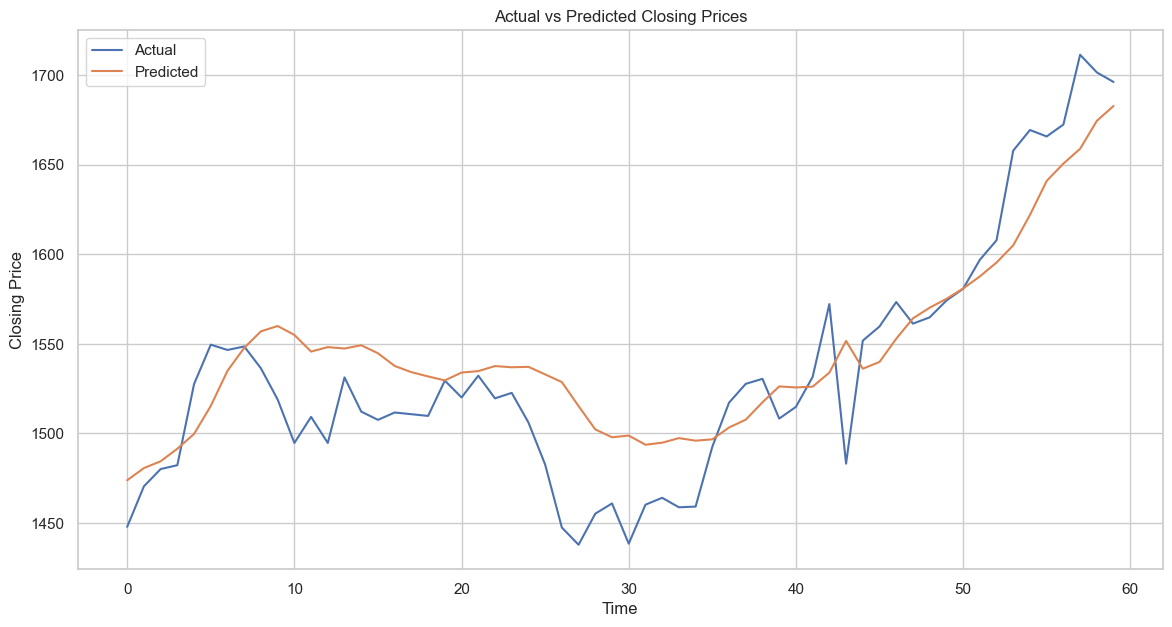

In [124]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# Set seeds for reproducibility
seed = 2024
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Inverse transform the target column separately
y_train_inv = scaler.inverse_transform(np.hstack((np.zeros((y_train.shape[0], X_train.shape[2])), y_train.reshape(-1, 1))))[:, -1]
y_test_inv = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], X_test.shape[2])), y_test.reshape(-1, 1))))[:, -1]

# Make predictions on the training dataset
y_train_pred = model.predict(X_train)
y_train_pred_inv = scaler.inverse_transform(np.hstack((np.zeros((y_train_pred.shape[0], X_train.shape[2])), y_train_pred)))[:, -1]

# Make predictions on the test dataset
y_test_pred = model.predict(X_test)
y_test_pred_inv = scaler.inverse_transform(np.hstack((np.zeros((y_test_pred.shape[0], X_test.shape[2])), y_test_pred)))[:, -1]

# Calculate RMSE and MAPE for training data
rmse_train = np.sqrt(mean_squared_error(y_train_inv, y_train_pred_inv))
mape_train = mean_absolute_percentage_error(y_train_inv, y_train_pred_inv)

# Calculate RMSE and MAPE for testing data
rmse_test = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_inv))
mape_test = mean_absolute_percentage_error(y_test_inv, y_test_pred_inv)

print(f"Training RMSE: {rmse_train}")
print(f"Training MAPE: {mape_train}")
print(f"Testing RMSE: {rmse_test}")
print(f"Testing MAPE: {mape_test}")

# Plot the actual vs. predicted values
plt.figure(figsize=(14, 7))  # Define the figure size
plt.plot(y_test_inv, label='Actual')
plt.plot(y_test_pred_inv, label='Predicted')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

# Save the plot before showing it
plot_filename = f'Test Performance GRU - {ticker}.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')  # Save with high DPI and tight bounding box

# Show the plot
plt.show()

In [125]:
# Set seeds for reproducibility
seed = 2024
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Scale the future values
future_scaled = scaler.transform([future])

# Create sequence from the last `time_steps` entries of the training data
last_sequence = scaled_data[-time_steps:, :-1]
last_sequence = np.append(last_sequence, future_scaled[:, :-1], axis=0)[-time_steps:]

# Reshape for prediction
last_sequence = np.expand_dims(last_sequence, axis=0)

# Predict the future value
future_pred = model.predict(last_sequence)

# Inverse transform the prediction
future_pred_inv = scaler.inverse_transform(np.hstack((np.zeros((future_pred.shape[0], last_sequence.shape[2])), future_pred)))[:, -1]

# Calculate RMSE and MAPE for the future value
future_actual = future[target]
rmse_future = np.sqrt(mean_squared_error([future_actual], future_pred_inv))
mape_future = mean_absolute_percentage_error([future_actual], future_pred_inv)

print(f"Future RMSE: {rmse_future}")
print(f"Future MAPE: {mape_future}")
print(f"Actual Value: {future_actual}")
print(f"Forecast : {future_pred_inv}")

1/1 [==============================] - 0s 120ms/step
Future RMSE: 0.4342632794293877
Future MAPE: 0.0002579066794108329
Actual Value: 1683.800049
Forecast : [1683.36578572]


In [126]:
# # Combine actual and predicted values into a DataFrame
# results = pd.DataFrame({'Actual': y_test_inv, 'Predicted': y_test_pred_inv})

# # Save the results to a CSV file
# results.to_csv(f'{ticker}_gru_test_results.csv', index=False)
# print(f"Results saved to {ticker}_gru_test_results.csv")


In [127]:
# import shap
# # Create an explainer
# explainer = shap.GradientExplainer(model, X_train)
# # Compute SHAP values for the training and test sets
# shap_values_train = explainer.shap_values(X_train)
# shap_values_test = explainer.shap_values(X_test)

In [128]:
# # Set seeds for reproducibility
# seed = 2024
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)

# # Ensure that the SHAP library is initialized
# shap.initjs()

# # Compute SHAP values for the future instance using the existing explainer
# shap_values_future = explainer.shap_values(last_sequence)

# # Aggregate SHAP values across all time steps for each feature
# shap_values_aggregated = np.sum(shap_values_future[0], axis=0).flatten()

# # Extract the feature values for the last time step (most recent values before prediction)
# data_last_time_step = last_sequence[0, -1, :]  # Include all features

# # Create a full feature row including the target to use scaler.inverse_transform
# full_feature_row = np.zeros((1, len(features) + 1))
# full_feature_row[0, :-1] = data_last_time_step

# # Inverse transform the feature values to get them back to their original scale
# full_feature_row_unscaled = scaler.inverse_transform(full_feature_row)
# data_last_time_step_unscaled = full_feature_row_unscaled[0, :-1]  # Remove the appended zero for the target

# # Calculate the expected value (base value) manually
# expected_value_scaled = model.predict(X_train).mean()
# expected_value_unscaled = scaler.inverse_transform([[0] * len(features) + [expected_value_scaled]])[0, -1]

# # Use the forecasted value stored in future_pred_inv
# future_prediction_unscaled = future_pred_inv

# # Adjust SHAP values to match the forecast and expected value
# scaling_factor = (future_prediction_unscaled - expected_value_unscaled) / shap_values_aggregated.sum()
# shap_values_rescaled = shap_values_aggregated * scaling_factor

# # Create the waterfall plot with unscaled data
# plt.title('SHAP Waterfall Breakdown')
# shap.waterfall_plot(shap.Explanation(values=shap_values_rescaled, 
#                                      base_values=expected_value_unscaled, data=data_last_time_step_unscaled, feature_names=features),
#                     max_display=len(features),
#     show=False  # Disable automatic display
# )

# # Save the plot with a proper resolution
# plot_filename = f'{os.path.splitext(ticker)[0]}_SHAPWaterfall_performance_plot.png'
# plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
# plt.show()
# plt.close()

In [129]:
# # Aggregate SHAP values over time steps by summing absolute values
# shap_values_train_aggregated = np.sum(np.abs(shap_values_train), axis=1).reshape(X_train.shape[0], -1)
# shap_values_test_aggregated = np.sum(np.abs(shap_values_test), axis=1).reshape(X_test.shape[0], -1)

# # Aggregate the corresponding features by taking the mean across time steps
# X_train_aggregated = np.mean(X_train, axis=1)
# X_test_aggregated = np.mean(X_test, axis=1)

# # Plot the summary plot for feature importance (Train Data)
# plt.figure(figsize=(10, 6))
# shap.summary_plot(shap_values_train_aggregated, features=X_train_aggregated, feature_names=features, show=False)
# plt.title('SHAP Summary Plot for Training Data')
# plot_filename = f'{os.path.splitext(ticker)[0]}_SHAPSummaryTrain_performance_plot.png'
# plt.savefig(plot_filename)
# plt.show()
# plt.close()

# # Plot the summary plot for feature importance (Test Data)
# plt.figure(figsize=(10, 6))
# shap.summary_plot(shap_values_test_aggregated, features=X_test_aggregated, feature_names=features, show=False)
# plt.title('SHAP Summary Plot for Test Data')
# plot_filename = f'{os.path.splitext(ticker)[0]}_SHAPSummaryTest_performance_plot.png'
# plt.savefig(plot_filename)
# plt.show()
# plt.close()

In [130]:
# import seaborn as sns
# import numpy as np
# import matplotlib.pyplot as plt

# sns.set(style="whitegrid")

# # Function to plot and save SHAP values over time
# def plot_shap_values_over_time(shap_values, X, feature_names, title_prefix, ticker, save_path=None):
#     num_features = len(feature_names)
#     time_steps = X.shape[1]
    
#     # Adjust the figure size with a reduced height
#     fig, axes = plt.subplots(nrows=num_features // 5 + (num_features % 5 != 0), ncols=5, figsize=(30, num_features))
#     axes = axes.flatten()
    
#     for i, feature in enumerate(feature_names):
#         shap_values_feature = np.array([shap[:, i] for shap in shap_values]).reshape(-1, time_steps)
#         mean_shap_values = np.mean(np.abs(shap_values_feature), axis=0)
        
#         # Normalize the mean SHAP values to the range [0, 1]
#         mean_shap_values = (mean_shap_values - mean_shap_values.min()) / (mean_shap_values.max() - mean_shap_values.min())
        
#         time_steps_labels = [f't-{j}' for j in range(time_steps-1, -1, -1)]
        
#         sns.barplot(ax=axes[i], x=time_steps_labels, y=mean_shap_values, dodge=False, palette='Blues_d', legend=False)
#         axes[i].set_title(f'{title_prefix} SHAP Values for {feature} Over Different Time Steps')
#         axes[i].set_xlabel('Time Steps')
#         axes[i].set_ylabel('Normalized Mean |SHAP Value|')

#     # Hide any empty subplots
#     for j in range(i + 1, len(axes)):
#         fig.delaxes(axes[j])

#     plt.tight_layout()

#     # Save the plot with the specified file name
#     if save_path:
#         plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
#     # Display the plot
#     plt.show()

# # Plot SHAP values for each feature in the test data and save the plot
# plot_shap_values_over_time(shap_values_test, X_test, features, 'Test', ticker, save_path=f'SHAP for GRU sequence {ticker}.png')


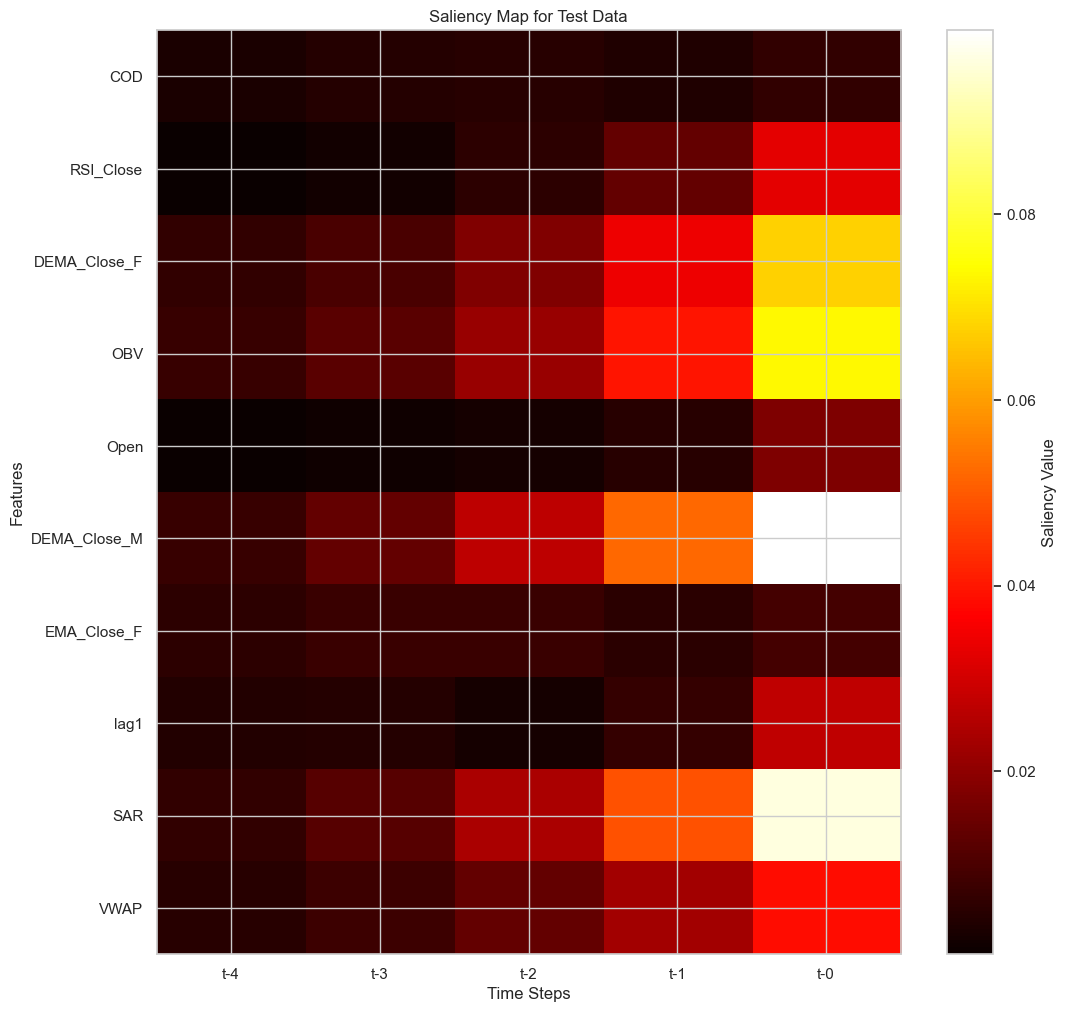

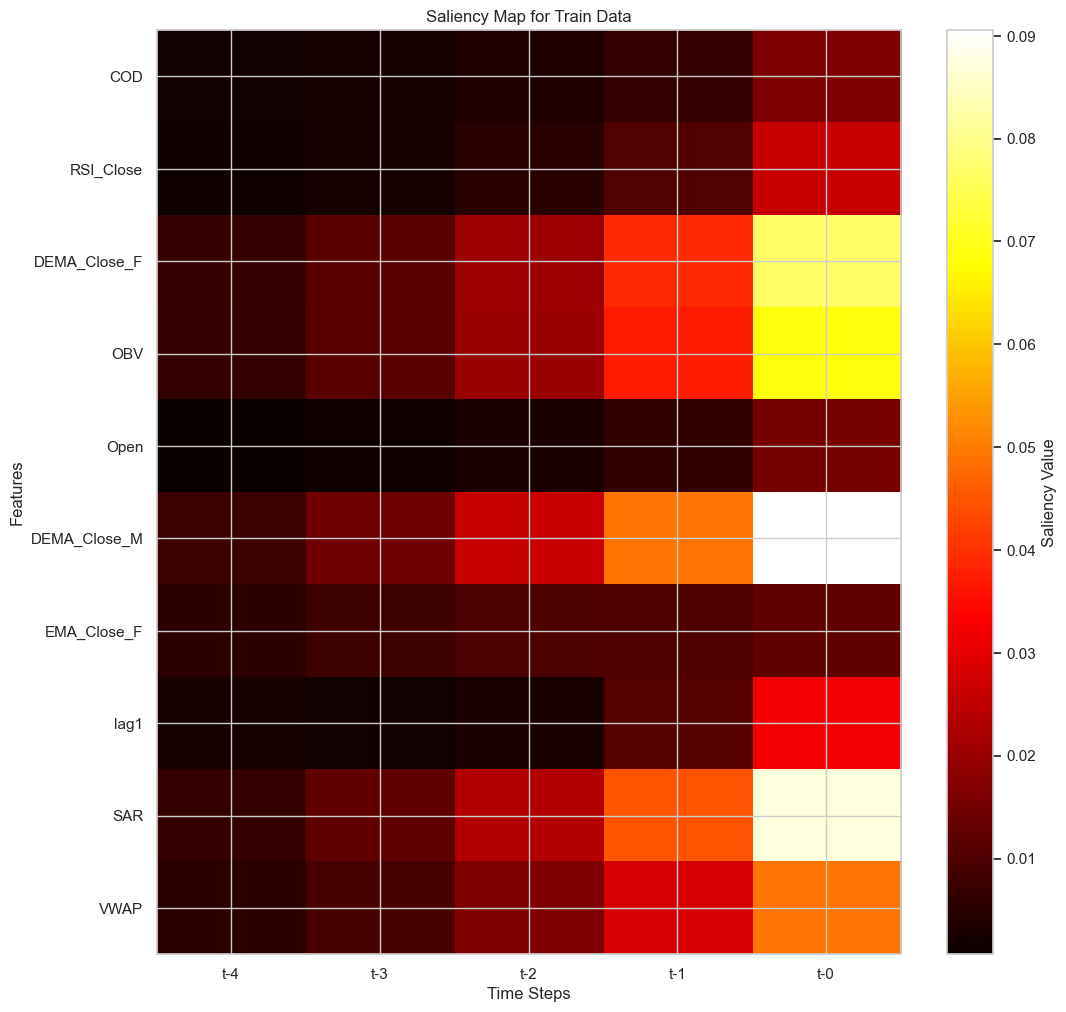

In [131]:
# Convert numpy arrays to tensors
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)

# Function to compute saliency map
def compute_saliency_map(model, X):
    with tf.GradientTape() as tape:
        tape.watch(X)
        predictions = model(X)
    gradients = tape.gradient(predictions, X)
    return tf.abs(gradients).numpy()

# Compute saliency maps for test data
saliency_maps_test = compute_saliency_map(model, X_test_tensor)
saliency_maps_train = compute_saliency_map(model, X_train_tensor)

def plot_saliency_map(saliency_map, feature_names, title="Saliency Map"):
    mean_saliency_map = np.mean(saliency_map, axis=0)  # Average over samples
    plt.figure(figsize=(12, 12))
    plt.imshow(mean_saliency_map.T, cmap='hot', interpolation='nearest', aspect='auto')
    plt.colorbar(label='Saliency Value')
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Features')
    plt.xticks(ticks=np.arange(saliency_map.shape[1]), labels=[f't-{i}' for i in range(saliency_map.shape[1]-1, -1, -1)])
    plt.yticks(ticks=np.arange(len(feature_names)), labels=feature_names)

# Plot saliency map for the test data
plot_saliency_map(saliency_maps_test, features, title="Saliency Map for Test Data")
plot_filename = f'{os.path.splitext(ticker)[0]}_SaliencyTest_plot.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Plot saliency map for the train data
plot_saliency_map(saliency_maps_train, features, title="Saliency Map for Train Data")
plot_filename = f'{os.path.splitext(ticker)[0]}_SaliencyTrain_plot.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [132]:
import lime
import lime.lime_tabular
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

# Aggregate the training data over time steps by averaging
X_train_aggregated = np.mean(X_train, axis=1)

# Define the LIME explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_aggregated,
    feature_names=features,
    class_names=['Price'],
    mode='regression'
)

# Scale the future values
future_scaled = scaler.transform([future])

# Create sequence from the last `time_steps` entries of the training data
last_sequence = scaled_data[-time_steps:, :-1]
last_sequence = np.append(last_sequence, future_scaled[:, :-1], axis=0)[-time_steps:]

# Aggregate the last sequence over time steps by averaging
last_sequence_aggregated = np.mean(last_sequence, axis=0).reshape(1, -1)

# Define a function for LIME to use linear regression as a surrogate model
def predict_with_surrogate(data):
    surrogate_model = LinearRegression()
    surrogate_model.fit(X_train_aggregated, y_train)
    return surrogate_model.predict(data)

# Compute LIME explanations for the "future" instance
exp = explainer_lime.explain_instance(last_sequence_aggregated[0], predict_with_surrogate, num_features=10)

lime.f = (exp.local_pred[0] * (data['Close'].max() - data['Close'].min()) + data['Close'].min())
mape = 100*abs(future_actual - lime.f)/future_actual
f'LIME forecast: {lime.f:.2f} MAPE: {mape:.2f}%'

# Plot the explanation
fig = exp.as_pyplot_figure()
plt.title(f'Prediction: {lime.f:.2f} \n MAPE: {mape:.2f}%', fontsize=10)
plt.xlabel('Contribution to Prediction', fontsize=8)
plt.ylabel('Feature', fontsize=8)
plt.gcf().set_size_inches(7, 5.8)
plt.tight_layout()
# Save the plot before showing it
plot_filename = f'{os.path.splitext(ticker)[0]}_LIME.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
# plt.show()
plt.close()


2/2 [==============================] - 0s 8ms/step


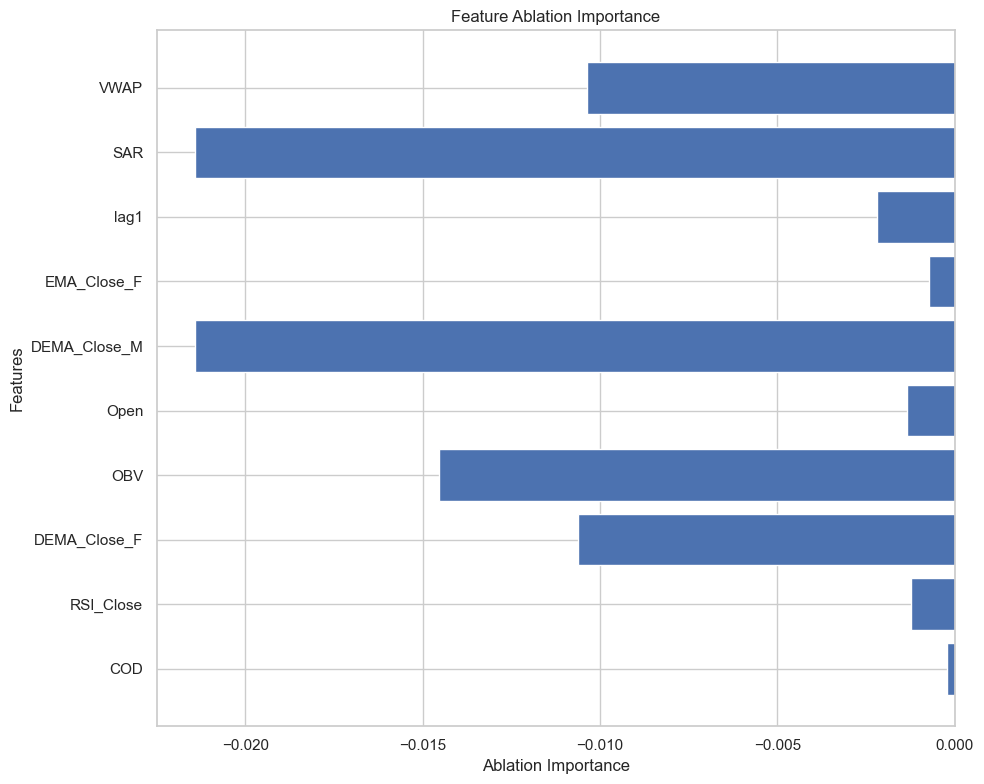

In [133]:
def feature_ablation(model, X, y, feature_names):
    base_score = mean_squared_error(y, model.predict(X))
    scores = []

    for i in range(X.shape[-1]):
        X_ablated = X.copy()
        X_ablated[:, :, i] = 0  # Ablate the feature
        score = mean_squared_error(y, model.predict(X_ablated))
        scores.append(base_score - score)

    plt.figure(figsize=(10, 8))
    plt.barh(feature_names, scores)
    plt.xlabel('Ablation Importance')
    plt.ylabel('Features')
    plt.title('Feature Ablation Importance')
    plt.tight_layout()
    
    # Save the plot before showing it
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Compute feature ablation scores with actual feature names
plot_filename = f'{os.path.splitext(ticker)[0]}_FeatureAblation_plot.png'
feature_ablation(model, X_test, y_test, features)

In [134]:
# Feature level Attention
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

input_features = 10

# Define the GRU model with attention over features
input_layer = tf.keras.Input(shape=(time_steps, input_features))
lstm_layer = tf.keras.layers.GRU(units = units,activation = activation, recurrent_dropout=recurrent_dropout_rate, return_sequences=True)(input_layer)

# Reshape GRU output to (batch_size, time_steps, features) and then apply attention over the features
attention_scores = tf.keras.layers.Dense(input_features, activation='softmax')(lstm_layer)
# Apply attention scores to the input features
context_vector = tf.keras.layers.Multiply()([attention_scores, input_layer])
# Summarize the context vector to get a single vector
context_vector = tf.keras.layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(context_vector)
# Add a dense layer for output
output_layer = tf.keras.layers.Dense(1)(context_vector)

model_with_attention = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_with_attention.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_with_attention.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

# Extract attention weights
attention_model = tf.keras.Model(inputs=model_with_attention.input, outputs=attention_scores)
attention_weights = attention_model.predict(X_test)


Epoch 1/100
47/47 [==============================] - 3s 14ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 2/100
47/47 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 3/100
47/47 [==============================] - 0s 10ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 4/100
47/47 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 5/100
47/47 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 6/100
47/47 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 8/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 9/100
47/47 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 10/100
47/47 [==============================] - 0s 6ms/step - loss: 9.3241e-04 - val_loss: 7.7339e-

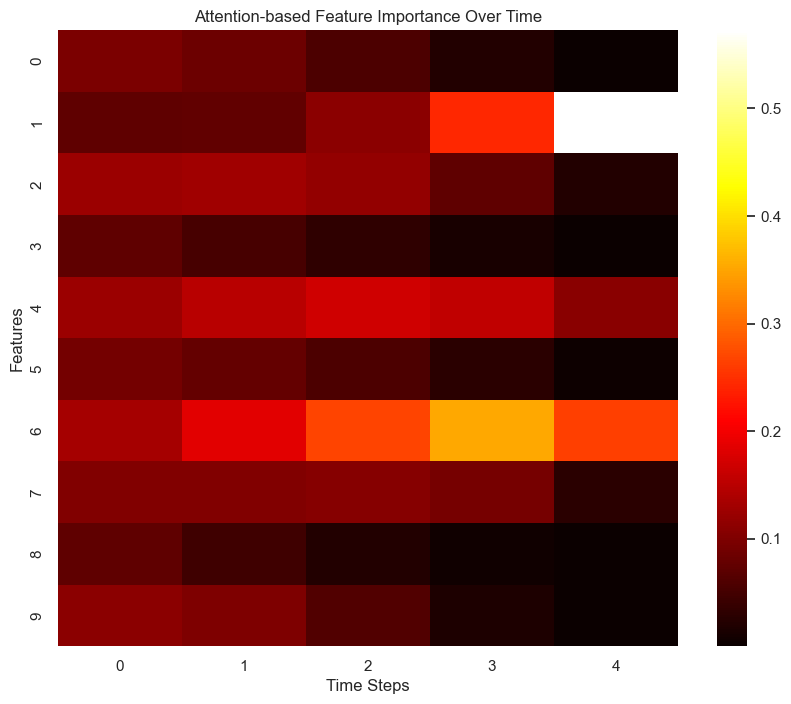

In [135]:
# Average attention across all test samples to get a general view
average_attention_weights = attention_weights.mean(axis=0)  # Shape will be (time_steps, features)

# Plot average attention weights
plt.figure(figsize=(10, 8))
sns.heatmap(average_attention_weights.T, cmap='hot', annot=False)
plt.title('Attention-based Feature Importance Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Features')
# Save the plot before showing it
plot_filename = f'{os.path.splitext(ticker)[0]}_Global Attention.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [136]:
from tensorflow.keras.layers import Input, Dense, GRU, LSTM, Permute, Reshape, multiply
from tensorflow.keras.models import Model

# Adjusted attention function
def attention(inputs, SHAPE):
    n_steps = int(inputs.shape[1]) 
    a = Permute((2, 1))(inputs) 
    a = Dense(n_steps, activation='softmax', name='attention_vec')(a)
    a = Permute((2, 1))(a)
    output_attention_mul = multiply([inputs, a])
    return output_attention_mul

# Function to create the model
def create_model(optimizer="adam", dropout=0.3, dense_nparams1=units, lr=0.01, n_wind=25):
    input_layer = Input(shape=(n_wind, n_features)) 
    x = attention(input_layer, n_features)
    x = GRU(dense_nparams1, activation=activation, return_sequences=False, recurrent_dropout=dropout)(x)
    preds = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=preds)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

n_features = len(features)  # Number of features
n_wind = time_steps  # Number of time steps
model = create_model(optimizer="adam", dropout=recurrent_dropout_rate, dense_nparams1=units, lr=learning_rate, n_wind=n_wind)

model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test))

# Predict the future value using the trained model
last_sequence = scaled_data[-n_wind:, :-1]  # Last sequence from training data
last_sequence = np.append(last_sequence, future_scaled[:, :-1], axis=0)[-n_wind:]  # Include the future data
last_sequence = np.expand_dims(last_sequence, axis=0)

# Predict the future value
future_pred = model.predict(last_sequence)
future_pred_inv = scaler.inverse_transform(np.hstack((np.zeros((future_pred.shape[0], last_sequence.shape[2])), future_pred)))[:, -1]

# Extract the attention activations for the future forecast
extract_attention_model = Model(inputs=model.input, outputs=model.get_layer('attention_vec').output)
future_attention = extract_attention_model.predict(last_sequence)

# Reshape the activations for plotting
future_attention_reshaped = future_attention.reshape(last_sequence.shape[0], last_sequence.shape[2], last_sequence.shape[1])

# Extract the attention activations for the future forecast
extract_attention_model = Model(inputs=model.input, outputs=model.get_layer('attention_vec').output)
future_attention = extract_attention_model.predict(last_sequence)

# Reshape the activations for plotting
future_attention_reshaped = future_attention.reshape(last_sequence.shape[0], last_sequence.shape[2], last_sequence.shape[1])

import matplotlib.colors as mcolors

# Custom normalization that amplifies small values
class CustomNormalize(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, clip=False):
        super().__init__(vmin, vmax, clip)
        self.scaling_factor = 10  # Amplification factor for small values

    def __call__(self, value, clip=None):
        return np.ma.masked_array(value * self.scaling_factor, mask=np.isnan(value))

Epoch 1/100
47/47 [==============================] - 3s 14ms/step - loss: 0.0703 - val_loss: 0.0032
Epoch 2/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0053 - val_loss: 0.0023
Epoch 3/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 4/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 5/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 6/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 9.8010e-04
Epoch 7/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 9.2628e-04
Epoch 8/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 8.6117e-04
Epoch 9/100
47/47 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 9.3579e-04
Epoch 10/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0010 - val_loss:

In [137]:
# Calculate RMSE and MAPE for the future value
future_actual = future[target]
rmse_future = np.sqrt(mean_squared_error([future_actual], future_pred_inv))
mape_future = mean_absolute_percentage_error([future_actual], future_pred_inv)
print(f"Future RMSE: {rmse_future}")
print(f"Future MAPE: {mape_future}")
print(f"Actual Value: {future_actual}")
print(f"Forecast : {future_pred_inv}")

Future RMSE: 12.960161653148134
Future MAPE: 0.007696971894522219
Actual Value: 1683.800049
Forecast : [1670.83988735]


In [138]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Inverse transform the target column separately
y_train_inv = scaler.inverse_transform(np.hstack((np.zeros((y_train.shape[0], X_train.shape[2])), y_train.reshape(-1, 1))))[:, -1]
y_test_inv = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], X_test.shape[2])), y_test.reshape(-1, 1))))[:, -1]

# Make predictions on the training dataset
y_train_pred = model.predict(X_train)
y_train_pred_inv = scaler.inverse_transform(np.hstack((np.zeros((y_train_pred.shape[0], X_train.shape[2])), y_train_pred)))[:, -1]

# Make predictions on the test dataset
y_test_pred = model.predict(X_test)
y_test_pred_inv = scaler.inverse_transform(np.hstack((np.zeros((y_test_pred.shape[0], X_test.shape[2])), y_test_pred)))[:, -1]

# Calculate RMSE and MAPE for training data
rmse_train = np.sqrt(mean_squared_error(y_train_inv, y_train_pred_inv))
mape_train = mean_absolute_percentage_error(y_train_inv, y_train_pred_inv)

# Calculate RMSE and MAPE for testing data
rmse_test = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_inv))
mape_test = mean_absolute_percentage_error(y_test_inv, y_test_pred_inv)

print(f"Training RMSE: {rmse_train}")
print(f"Training MAPE: {mape_train}")
print(f"Testing RMSE: {rmse_test}")
print(f"Testing MAPE: {mape_test}")

# Plot the actual vs. predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_test_pred_inv, label='Predicted')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

# Save the plot before showing it
plot_filename = f'{os.path.splitext(ticker)[0]}_TestPerformanceWithAttention_plot.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')  # Save with high DPI and tight bounding box
plt.close()
# Show the plot
# plt.show()

2/2 [==============================] - 0s 3ms/step
Training RMSE: 22.290280427918166
Training MAPE: 0.01255226039420692
Testing RMSE: 24.72365197009193
Testing MAPE: 0.012197683762151789


In [139]:
# Plot the attention map for the chosen future forecast
fig, axs = plt.subplots(3, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [2, 3, 3]})

# 1. Time-Averaged Contribution Barplot
average_contribution = np.mean(future_attention_reshaped[0], axis=1)
axs[0].bar(range(len(average_contribution)), average_contribution, color='black')
axs[0].set_xticks(range(n_features))
axs[0].set_xticklabels(features, rotation=90)
axs[0].set_ylabel('Average Contribution')
axs[0].set_title('Time-Averaged Contribution of Each Feature')

# Reverse the time steps for better visualization
time_steps_reversed = list(range(n_wind))[::-1]

# 2. Attention Activations Heatmap
sns.heatmap(future_attention_reshaped[0], cmap='magma', ax=axs[1], norm=CustomNormalize(), cbar_kws={'label': 'Activation Level'})
axs[1].set_yticks(range(n_features))
axs[1].set_yticklabels(features, rotation=0)
axs[1].set_xticks(range(n_wind))
axs[1].set_xticklabels(time_steps_reversed)
axs[1].set_ylabel('Features')
axs[1].set_title('Attention Activations Heatmap')

# 3. Input Features Heatmap
sns.heatmap(last_sequence[0].T, cmap='coolwarm', ax=axs[2])
axs[2].set_yticks(range(n_features))
axs[2].set_yticklabels(features, rotation=0)
axs[2].set_xticks(range(n_wind))
axs[2].set_xticklabels(time_steps_reversed)
axs[2].set_ylabel('Features')
axs[2].set_title('Input Features Heatmap')

plt.tight_layout()
# Save the plot before showing it
plot_filename = f'{os.path.splitext(ticker)[0]}_Local Attention.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
# plt.show()
plt.close()

In [140]:
# import matplotlib.pyplot as plt
# import numpy as np
# import seaborn as sns
# from matplotlib.colors import LinearSegmentedColormap
# # Extract the unscaled test data from the original data
# original_features_test = data.iloc[-len(y_test):][features].values
# original_target_test = data.iloc[-len(y_test):][target].values

# # Define custom colormap: Red -> Orange -> Blue
# colors = [(0, 0, 1), (1, 0.65, 0), (1, 0, 0)]  # Blue -> Orange -> Red
# n_bins = 100  # Number of color levels
# cmap_name = 'custom_cmap'
# cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# # Set the seaborn style
# sns.set(style="whitegrid")

# # Create a figure with subplots
# fig, axes = plt.subplots(nrows=len(features) + 1, ncols=1, figsize=(8, 18), sharex=True)

# # Plot actual closing prices
# axes[0].plot(original_target_test, label='Actual Price', color='black', linewidth=2)
# axes[0].plot(y_test_pred_inv, label='Predicted Price', color='red',linewidth=2)
# axes[0].set_title('Actual Closing Price Over Time', fontsize=14)
# axes[0].set_ylabel('Price', fontsize=12)
# axes[0].legend(loc='lower right',fontsize=9,frameon=False)

# # Plot each feature with SHAP values
# for i, feature in enumerate(features):
#     axes[i + 1].plot(original_features_test[:, i], color='black', marker='o', markersize=4, label=feature, linestyle='-', linewidth=1.5)

#     # Normalize SHAP values for color mapping
#     shap_values = shap_values_test_aggregated[:, i]
#     norm_shap_values = (shap_values - np.min(shap_values)) / (np.max(shap_values) - np.min(shap_values))

#     # Apply custom colormap to the background
#     for j in range(len(shap_values)):
#         color = cmap(norm_shap_values[j])
#         axes[i + 1].axvspan(j - 0.5, j + 0.5, color=color, alpha=0.6)
        
#     axes[i + 1].set_title(f'{feature} (SHAP Impact)', fontsize=14)
#     axes[i + 1].set_ylabel(feature, fontsize=12)
#     axes[i + 1].legend().set_visible(False)

# # Adjust the overall layout
# fig.tight_layout(rect=[0, 0, 0.95, 1])
# fig.subplots_adjust(hspace=0.3)

# # Add color bar for SHAP values
# cbar_ax = fig.add_axes([0.96, 0.15, 0.02, 0.7])
# norm = plt.Normalize(0, 1)
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# cbar = fig.colorbar(sm, cax=cbar_ax)
# cbar.set_label('Normalized SHAP Value', fontsize=10)
# cbar.set_ticks([0, 1])
# # cbar.set_ticklabels(['Low (Blue)', 'Medium (Orange)', 'High (Red)'])

# # Save the plot before showing it
# plot_filename = f'{os.path.splitext(ticker)[0]}_SHAP over time.png'
# plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
# # plt.show()
# plt.close()


In [141]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# # Function to apply perturbation based on SHAP or Saliency Maps
# def apply_perturbation(X, map_values, threshold=0.7, method='swap'):
#     X_perturbed = np.copy(X)
#     for i in range(X.shape[0]):
#         # Identify important time steps based on SHAP/Saliency map
#         importance = np.abs(map_values[i])
#         important_indices = np.where(importance > np.percentile(importance, 100 * threshold))[0]
        
#         for idx in important_indices:
#             if method == 'swap':
#                 # Swap with neighboring time steps
#                 start = max(0, idx - 1)
#                 end = min(X.shape[1], idx + 2)
#                 X_perturbed[i, start:end] = X_perturbed[i, start:end][::-1]
#             elif method == 'mean':
#                 # Replace with mean value
#                 start = max(0, idx - 1)
#                 end = min(X.shape[1], idx + 2)
#                 mean_value = np.mean(X_perturbed[i, start:end], axis=0)
#                 X_perturbed[i, start:end] = mean_value
#             elif method == 'zero':
#                 # Set to zero
#                 X_perturbed[i, idx] = 0
#             elif method == 'permute':
#                 # Permute (randomize) the important indices
#                 np.random.shuffle(X_perturbed[i, idx])
#     return X_perturbed

# # Compute SHAP values (already done earlier)
# # shap_values_train = ...
# # shap_values_test = ...

# # Compute Saliency Maps (already done earlier)
# # saliency_maps_train = ...
# # saliency_maps_test = ...

# # Evaluate SHAP method
# X_test_shap_swap = apply_perturbation(X_test, shap_values_test, threshold=0.7, method='swap')
# X_test_shap_mean = apply_perturbation(X_test, shap_values_test, threshold=0.7, method='mean')
# X_test_shap_zero = apply_perturbation(X_test, shap_values_test, threshold=0.7, method='zero')
# X_test_shap_permute = apply_perturbation(X_test, shap_values_test, threshold=0.7, method='permute')

# # Evaluate Saliency method
# X_test_saliency_swap = apply_perturbation(X_test, saliency_maps_test, threshold=0.7, method='swap')
# X_test_saliency_mean = apply_perturbation(X_test, saliency_maps_test, threshold=0.7, method='mean')
# X_test_saliency_zero = apply_perturbation(X_test, saliency_maps_test, threshold=0.7, method='zero')
# X_test_saliency_permute = apply_perturbation(X_test, saliency_maps_test, threshold=0.7, method='permute')

# # Predict on original data
# y_test_pred = model.predict(X_test)

# # Predict on SHAP-perturbed datasets
# y_test_pred_shap_swap = model.predict(X_test_shap_swap)
# y_test_pred_shap_mean = model.predict(X_test_shap_mean)
# y_test_pred_shap_zero = model.predict(X_test_shap_zero)
# y_test_pred_shap_permute = model.predict(X_test_shap_permute)

# # Predict on Saliency-perturbed datasets
# y_test_pred_saliency_swap = model.predict(X_test_saliency_swap)
# y_test_pred_saliency_mean = model.predict(X_test_saliency_mean)
# y_test_pred_saliency_zero = model.predict(X_test_saliency_zero)
# y_test_pred_saliency_permute = model.predict(X_test_saliency_permute)

# # Calculate RMSE and MAPE for SHAP-perturbed datasets
# rmse_shap_swap = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_shap_swap))
# mape_shap_swap = mean_absolute_percentage_error(y_test_inv, y_test_pred_shap_swap)

# rmse_shap_mean = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_shap_mean))
# mape_shap_mean = mean_absolute_percentage_error(y_test_inv, y_test_pred_shap_mean)

# rmse_shap_zero = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_shap_zero))
# mape_shap_zero = mean_absolute_percentage_error(y_test_inv, y_test_pred_shap_zero)

# rmse_shap_permute = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_shap_permute))
# mape_shap_permute = mean_absolute_percentage_error(y_test_inv, y_test_pred_shap_permute)

# # Calculate RMSE and MAPE for Saliency-perturbed datasets
# rmse_saliency_swap = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_saliency_swap))
# mape_saliency_swap = mean_absolute_percentage_error(y_test_inv, y_test_pred_saliency_swap)

# rmse_saliency_mean = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_saliency_mean))
# mape_saliency_mean = mean_absolute_percentage_error(y_test_inv, y_test_pred_saliency_mean)

# rmse_saliency_zero = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_saliency_zero))
# mape_saliency_zero = mean_absolute_percentage_error(y_test_inv, y_test_pred_saliency_zero)

# rmse_saliency_permute = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_saliency_permute))
# mape_saliency_permute = mean_absolute_percentage_error(y_test_inv, y_test_pred_saliency_permute)

# # Print the results
# print(f"Original Testing RMSE: {rmse_test}")
# print(f"Original Testing MAPE: {mape_test}")
# print(f"Testing RMSE after SHAP Swap: {rmse_shap_swap}")
# print(f"Testing MAPE after SHAP Swap: {mape_shap_swap}")
# print(f"Testing RMSE after SHAP Mean: {rmse_shap_mean}")
# print(f"Testing MAPE after SHAP Mean: {mape_shap_mean}")
# print(f"Testing RMSE after SHAP Zero: {rmse_shap_zero}")
# print(f"Testing MAPE after SHAP Zero: {mape_shap_zero}")
# print(f"Testing RMSE after SHAP Permute: {rmse_shap_permute}")
# print(f"Testing MAPE after SHAP Permute: {mape_shap_permute}")

# print(f"Testing RMSE after Saliency Swap: {rmse_saliency_swap}")
# print(f"Testing MAPE after Saliency Swap: {mape_saliency_swap}")
# print(f"Testing RMSE after Saliency Mean: {rmse_saliency_mean}")
# print(f"Testing MAPE after Saliency Mean: {mape_saliency_mean}")
# print(f"Testing RMSE after Saliency Zero: {rmse_saliency_zero}")
# print(f"Testing MAPE after Saliency Zero: {mape_saliency_zero}")
# print(f"Testing RMSE after Saliency Permute: {rmse_saliency_permute}")
# print(f"Testing MAPE after Saliency Permute: {mape_saliency_permute}")

# # Plot the results for SHAP
# metrics_shap = ['Original', 'Swap', 'Mean', 'Zero', 'Permute']
# rmse_values_shap = [rmse_test, rmse_shap_swap, rmse_shap_mean, rmse_shap_zero, rmse_shap_permute]
# mape_values_shap = [mape_test, mape_shap_swap, mape_shap_mean, mape_shap_zero, mape_shap_permute]

# index = np.arange(len(metrics_shap))

# fig, ax1 = plt.subplots(figsize=(14, 8))

# bar_width = 0.35

# bars1 = ax1.bar(index, rmse_values_shap, bar_width, color='blue', alpha=0.6, label='RMSE')
# ax1.set_xlabel('SHAP Perturbation Methods')
# ax1.set_ylabel('RMSE', color='blue')
# ax1.set_title('Comparison of RMSE and MAPE across Original and Different SHAP Perturbation Methods')
# ax1.set_xticks(index)
# ax1.set_xticklabels(metrics_shap)

# ax2 = ax1.twinx()
# bars2 = ax2.bar(index + bar_width, mape_values_shap, bar_width, color='orange', alpha=0.6, label='MAPE')
# ax2.set_ylabel('MAPE', color='orange')
# ax2.tick_params(axis='y', labelcolor='orange')

# ax1.legend([bars1, bars2], ['RMSE', 'MAPE'], loc='upper left')

# plt.tight_layout()
# plt.show()

# # Plot the results for Saliency
# metrics_saliency = ['Original', 'Swap', 'Mean', 'Zero', 'Permute']
# rmse_values_saliency = [rmse_test, rmse_saliency_swap, rmse_saliency_mean, rmse_saliency_zero, rmse_saliency_permute]
# mape_values_saliency = [mape_test, mape_saliency_swap, mape_saliency_mean, mape_saliency_zero, mape_saliency_permute]

# index = np.arange(len(metrics_saliency))

# fig, ax1 = plt.subplots(figsize=(14, 8))

# bar_width = 0.35

# bars1 = ax1.bar(index, rmse_values_saliency, bar_width, color='blue', alpha=0.6, label='RMSE')
# ax1.set_xlabel('Saliency Perturbation Methods')
# ax1.set_ylabel('RMSE', color='blue')
# ax1.set_title('Comparison of RMSE and MAPE across Original and Different Saliency Perturbation Methods')
# ax1.set_xticks(index)
# ax1.set_xticklabels(metrics_saliency)

# ax2 = ax1.twinx()
# bars2 = ax2.bar(index + bar_width, mape_values_saliency, bar_width, color='orange', alpha=0.6, label='MAPE')
# ax2.set_ylabel('MAPE', color='orange')
# ax2.tick_params(axis='y', labelcolor='orange')

# ax1.legend([bars1, bars2], ['RMSE', 'MAPE'], loc='upper left')

# plt.tight_layout()
# plt.show()


In [142]:
print(f'XAI done for {ticker}')

XAI done for HDFCBANK.NS
